<a href="https://colab.research.google.com/github/tronghieu2810/COMPUTER_VISION/blob/main/UDM_Lazy_Programmer_Inc_De_Le_Ad_Co_Vi/Blood%20Cell%20Images%20ResNet-Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D,\
    MaxPooling2D, add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip
!unzip -nq blood_cell_images.zip
!ls

--2022-03-16 12:17:10--  https://lazyprogrammer.me/course_files/blood_cell_images.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  18.9MB/s    in 9.7s    

2022-03-16 12:17:21 (10.8 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [3]:
# Resize all images to this
IMAGE_SIZE = [224, 224]

# Training config
epochs     = 16
batch_size = 128

In [4]:
train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'

In [5]:
# Useful for getting number of files
image_files       = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
# Useful for getting number of classes
folders = glob(train_path + '/*')

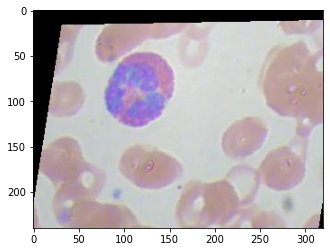

In [6]:
# Look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [7]:
def identity_block(input_, kernel_size, filters):
    # 03 filter sizes
    f1, f2, f3 = filters
    
    x = Conv2D(filters=f1, kernel_size=(1, 1), kernel_initializer='he_normal')(input_)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters=f2, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters=f3, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = add([x, input_])
    x = Activation(activation='relu')(x)
    
    return x

In [8]:
def conv_block(input_, kernel_size, filters, strides=(2, 2)):
    f1, f2, f3 = filters
    
    x = Conv2D(filters=f1, kernel_size=(1, 1), strides=strides, kernel_initializer='he_normal')(input_)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters=f2, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters=f3, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=strides, kernel_initializer='he_normal')(input_)
    shortcut = BatchNormalization()(shortcut)
    
    x = add([x, shortcut])
    x = Activation(activation='relu')(x)
    
    return x

In [9]:
# Custom ResNet
i = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation(activation='relu')(x)

x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = conv_block    (input_=x, kernel_size=3, filters=[64, 64, 256], strides=(1, 1))
x = identity_block(input_=x, kernel_size=3, filters=[64, 64, 256])
x = identity_block(input_=x, kernel_size=3, filters=[64, 64, 256])

x = conv_block    (input_=x, kernel_size=3, filters=[128, 128, 512])
x = identity_block(input_=x, kernel_size=3, filters=[128, 128, 512])
x = identity_block(input_=x, kernel_size=3, filters=[128, 128, 512])
x = identity_block(input_=x, kernel_size=3, filters=[128, 128, 512])

# The head of NN
x = Flatten()(x)
prediction = Dense(len(folders), activation='softmax')(x)

# A model object
model = Model(inputs=i, outputs=prediction)

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# The model's structure
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [10]:
# Create an instance of ImageDataGenerator
def preprocess_input2(x):
    x /= 127.5
    x -= 1.
    return x

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input2
)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input2)

# Create generators
train_generator = train_gen.flow_from_directory(
    directory=train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)
valid_generator = val_gen.flow_from_directory(
    directory=valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [11]:
# Fit the model
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch= len(image_files)       // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
    ]
)

Epoch 1/16
77/77 [==============================] - 219s 3s/step - loss: 7.5714 - accuracy: 0.2835 - val_loss: 3.8373 - val_accuracy: 0.2726
Epoch 2/16
77/77 [==============================] - 184s 2s/step - loss: 2.1763 - accuracy: 0.4427 - val_loss: 1.9875 - val_accuracy: 0.3729
Epoch 3/16
77/77 [==============================] - 178s 2s/step - loss: 1.1439 - accuracy: 0.6640 - val_loss: 1.6030 - val_accuracy: 0.4877
Epoch 4/16
77/77 [==============================] - 178s 2s/step - loss: 0.8978 - accuracy: 0.7716 - val_loss: 1.1021 - val_accuracy: 0.7068
Epoch 5/16
77/77 [==============================] - 178s 2s/step - loss: 0.6222 - accuracy: 0.8436 - val_loss: 1.0875 - val_accuracy: 0.7340
Epoch 6/16
77/77 [==============================] - 177s 2s/step - loss: 0.4385 - accuracy: 0.8842 - val_loss: 1.3307 - val_accuracy: 0.8141
Epoch 7/16
77/77 [==============================] - 176s 2s/step - loss: 0.2949 - accuracy: 0.9199 - val_loss: 0.9409 - val_accuracy: 0.8104
Epoch 8/16
77

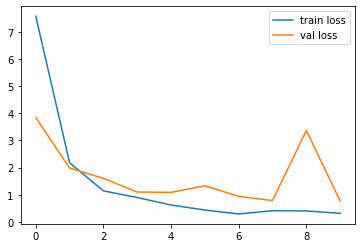

In [12]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

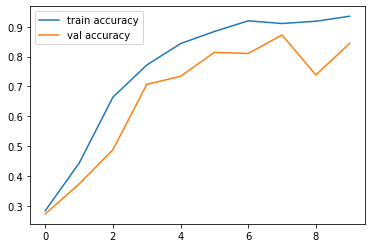

In [13]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [11]:
model.load_weights(checkpoint_filepath)

In [11]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets     = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)


In [ ]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
np.trace(cm) / cm.sum()


In [ ]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')
np.trace(valid_cm) / valid_cm.sum()